# Create  FMOX JSON Files

In [1]:
import os
import sys
import json
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
# Use the magic command to display plots inline
%matplotlib inline

In [3]:
# import download_datasets
import create_fmov2_json
import create_tbd_json
import dataset_loader.create_json_via_benchmark_loader as fmo_data_loader
import rle_to_seg_mask_img
import combine_all_mask_to_single_img
import tbd_visualize_bboxes

### Check if the dataset is not downloaded; if it is not, proceed to download it.

In [5]:
script_name = 'download_datasets'

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the script in the parent directory
script_path = os.path.abspath(os.path.join(current_dir, '..', f'{script_name}.py'))

# Check if the script exists
if not os.path.isfile(script_path):
    print(f"Script not found: {script_path}")
else:
    # Add the parent directory to the Python path
    parent_dir = os.path.dirname(script_path)
    sys.path.append(parent_dir)
    try:
        import download_datasets
        print("Module imported successfully.")
    except ImportError as e:
        print(f"Error importing module: {e}")

Module imported successfully.


In [9]:
""" The dataset is downloaded and extracted into a folder named "Original_Dataset". """
data_path = Path('../Original_Dataset')
if not data_path.exists():  # Check if the directory exists
    download_datasets.download_unzip_data(data_path)
else:
    # Check if the directory has files
    if list(data_path.iterdir()):  # folder is not empty, so pass
        pass
    else:
        download_datasets.download_unzip_data(data_path)

In [11]:
# Ensure the output directory exists
fmox_json_path = "../FMOX-Jsons"
os.makedirs(os.path.dirname(fmox_json_path), exist_ok=True)

In [13]:
"""Change "FMOv2/FMOv2" to "FMOv2/imgs" because other dataset has "imgs" - to run the code """

current_folder_name = "../Original_Dataset/FMOv2/FMOv2"
new_folder_name = "../Original_Dataset/FMOv2/imgs"

# Check if the new folder already exists
if os.path.exists(new_folder_name):
    print(f"The folder '{new_folder_name}' already exists. Skipping rename.")
else:
    try:
        os.rename(current_folder_name, new_folder_name)
        print(f"Folder renamed from '{current_folder_name}' to '{new_folder_name}'")
    except Exception as e:
        print(f"An error occurred: {e}")

The folder '../Original_Dataset/FMOv2/imgs' already exists. Skipping rename.


### Create FMOv2 JSON Annotation File

In [15]:
""" Contour detection is applied to the mask images to obtain bounding boxes. 
 During process, object size labels are calculated and saved in a JSON file. """

fmov2_img_path = "../Original_Dataset/FMOv2/FMOv2_gt"
fmov2_contour_out_path = "../Videos/fmov2_outputs/contour_videos/"
fmov2_json_save_path = "../FMOX-Jsons/FMOX_fmov2.json"

create_fmov2_json.get_fmov2_json(fmov2_img_path, fmov2_contour_out_path, fmov2_json_save_path)

JSON saved in: ../FMOX-Jsons/FMOX_fmov2.json, Videos saved in: ../Videos/fmov2_outputs/contour_videos/


### Create TbD JSON from provided Ground-truth trajectory text files

In [18]:
""" Ground-truth trajectory text files (gt.txt) used to obtain the bounding boxes for whole sequence of frames. 
 To obtain only FMO bounding boxes; please use code which provided for Falling Object, TbD-3D Datasets. 
 While obtaining the bounding boxes, object size labels are calculated and saved in a JSON file. """

tbd_img_path = "../Original_Dataset/TbD/imgs/"
tbd_json_save_path = "../FMOX-Jsons/FMOX_tbd_whole_sequence.json"
create_tbd_json.get_tbd_json(tbd_img_path, tbd_json_save_path)

Dataset path: ../Original_Dataset/TbD/imgs/, JSON saved in: ../FMOX-Jsons/FMOX_tbd_whole_sequence.json


### Create JSON Annotation File For Falling Object, TbD-3D Datasets
#### (To get Tbd from here (only FMO exists frames annotations)- uncomment lines 69 and 70, comment 71 in create_json file)

In [ ]:
""" - Acknowledgments: The code is provided (in "dataset_loader" folder) adapted 
from the [fmo-deblurring-benchmark](https://github.com/rozumden/fmo-deblurring-benchmark) and
some modifications (json format saving) made to fit our specific use case. For more details, please visit the repository.
- However if you want to regenerate it, please refer below file:"""

falling_path = '../Original_Dataset/Falling_Object'
tbd_path = '../Original_Dataset/TbD'
tbd3d_path = '../Original_Dataset/TbD-3D'
multi_data_json_save_path = "../FMOX-Jsons/FMOX_fall_and_tbd3d.json"
fmo_data_loader.create_json(falling_path, tbd_path, tbd3d_path, multi_data_json_save_path)

### Combine JSONS - create FMOX_All4.json

In [23]:
""" Note: if you get the TbD annotations with FMOX_fall_and_tbd3d.json dont insert 
'../FMOX-Jsons/FMOX_tbd.json' in following code """

json_files = ['../FMOX-Jsons/FMOX_fall_and_tbd3d.json',
              '../FMOX-Jsons/FMOX_fmov2.json',
              '../FMOX-Jsons/FMOX_tbd.json']

fmox_all4_json_path = '../FMOX-Jsons/FMOX_All4.json'
combined_databases = []

for json_file in json_files:
    try:
        with open(json_file, 'r') as file:
            data = json.load(file)
            combined_databases.extend(data.get('databases', []))  # Use .get to avoid KeyError

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in file {json_file}: {e}")
    except FileNotFoundError as e:
        print(f"File not found: {json_file}. Error: {e}")

combined_data = {"databases": combined_databases}  # Create a new combined structure

with open(fmox_all4_json_path, 'w') as json_file:
    json.dump(combined_data, json_file, indent=4)

print(f"Combined FMOX JSON saved to: {fmox_all4_json_path}")

Combined FMOX JSON saved to: ../FMOX-Jsons/FMOX_All4.json


   # ---------------- OTHER OPTIONAL CODES ----------------

### Convert FMOv2 Run-Length Encoded (RLE) Text Files to Mask Images 
#### (Masks already provided - could be useful if needed)

In [29]:
""" The segmentation mask images for the FMOv2 dataset have been compressed into text files using the
Run-Length Encoding (RLE) data compression technique. The following code can be used to convert these
compressed files back into black and white mask images. """

fmov2_path = "../Original_Dataset/FMOv2/"
fmov2_rle_to_mask_img_path = "../Videos/fmov2_outputs/rleTXT_to_video/"

# Ensure the output directory exists
os.makedirs(os.path.dirname(fmov2_rle_to_mask_img_path), exist_ok=True)

rle_to_seg_mask_img.rle_to_mask_img(fmov2_path, fmov2_rle_to_mask_img_path)

Saved combined image as ../Videos/fmov2_outputs/rleTXT_to_video/atp_serves_rle_combined_image.png Video saved as ../Videos/fmov2_outputs/rleTXT_to_video/atp_serves_fmov2_rle_out.avi
Saved combined image as ../Videos/fmov2_outputs/rleTXT_to_video/blue_rle_combined_image.png Video saved as ../Videos/fmov2_outputs/rleTXT_to_video/blue_fmov2_rle_out.avi
Saved combined image as ../Videos/fmov2_outputs/rleTXT_to_video/darts1_rle_combined_image.png Video saved as ../Videos/fmov2_outputs/rleTXT_to_video/darts1_fmov2_rle_out.avi
Saved combined image as ../Videos/fmov2_outputs/rleTXT_to_video/darts_window1_rle_combined_image.png Video saved as ../Videos/fmov2_outputs/rleTXT_to_video/darts_window1_fmov2_rle_out.avi
Saved combined image as ../Videos/fmov2_outputs/rleTXT_to_video/frisbee_rle_combined_image.png Video saved as ../Videos/fmov2_outputs/rleTXT_to_video/frisbee_fmov2_rle_out.avi
Saved combined image as ../Videos/fmov2_outputs/rleTXT_to_video/hockey_rle_combined_image.png Video saved as .

### Merge Mask Images to Visualize Trajectories

In [31]:
""" Below code could be utilized to visualize the trajectories of the object(s) on a single image. 
Since the FMOv2 dataset directly shares segmentation mask images, the path related to this dataset 
is provided below as input. """

fmov2_gt_path = '../Original_Dataset/FMOv2/FMOv2_gt'
fmov2_mask_traj_save_path = "../Videos/fmov2_outputs/"

combine_all_mask_to_single_img.combine_segmentation_images(fmov2_gt_path, fmov2_mask_traj_save_path)

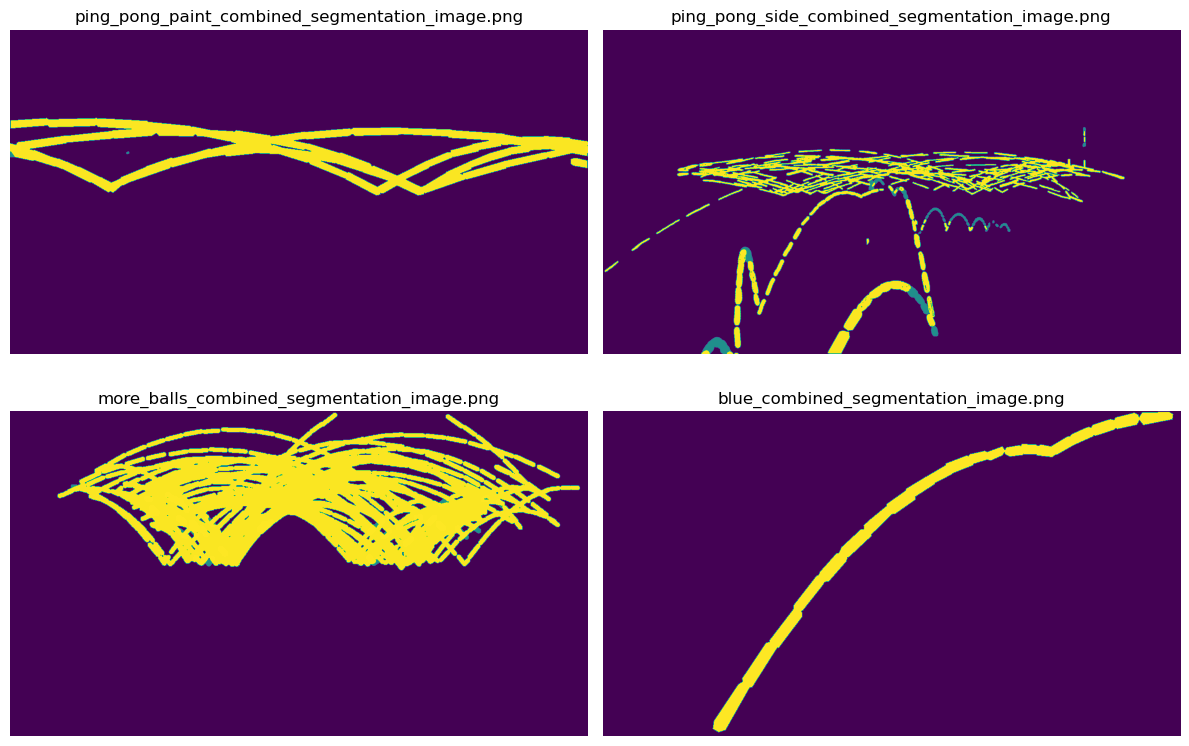

In [39]:
""" Display a sample output """
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List all files in the directory
image_files = os.listdir(fmov2_mask_traj_save_path)
# Filter for image files (you can adjust the extensions as needed)
image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
# Randomly select 6 images
selected_images = random.sample(image_files, 4) if len(image_files) >= 6 else image_files

plt.figure(figsize=(12, 8))
for i, image_file in enumerate(selected_images):
    img = mpimg.imread(os.path.join(fmov2_mask_traj_save_path, image_file))
    plt.subplot(2, 2, i + 1)  # 3 rows, 2 columns
    # Extract and display the title part from the filename
    # Format: efficientTAM_traj_Falling_Object_v_box_GTgamma.jpg -> Falling_Object_v_box_GTgamma
    title_part = image_file
    # if image_file.startswith("efficientTAM_traj_"):
    #     title_part = image_file[len("efficientTAM_traj_"):]
    # title_part = os.path.splitext(title_part)[0]
    
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(title_part)
plt.tight_layout()
plt.show()

### TbD Dataset Bounding Box Visualization from gt.txt files

In [43]:
tbd_single_seq_path = "../Original_Dataset/TbD-3D/imgs/HighFPS_GT_depth2/"  # HighFPS_GT_depth2, fall_cube etc.
tbd_single_seq_output_path = "../Videos//TbD-3D/bbox_drawings"
tbd_visualize_bboxes.tbd_vis_bbox(tbd_single_seq_path, tbd_single_seq_output_path)

Processed image 1/48: ../Videos//TbD-3D/bbox_drawings\00000000_annotated.png
Processed image 2/48: ../Videos//TbD-3D/bbox_drawings\00000001_annotated.png
Processed image 3/48: ../Videos//TbD-3D/bbox_drawings\00000002_annotated.png
Processed image 4/48: ../Videos//TbD-3D/bbox_drawings\00000003_annotated.png
Processed image 5/48: ../Videos//TbD-3D/bbox_drawings\00000004_annotated.png
Processed image 6/48: ../Videos//TbD-3D/bbox_drawings\00000005_annotated.png
Processed image 7/48: ../Videos//TbD-3D/bbox_drawings\00000006_annotated.png
Processed image 8/48: ../Videos//TbD-3D/bbox_drawings\00000007_annotated.png
Processed image 9/48: ../Videos//TbD-3D/bbox_drawings\00000008_annotated.png
Processed image 10/48: ../Videos//TbD-3D/bbox_drawings\00000009_annotated.png
Processed image 11/48: ../Videos//TbD-3D/bbox_drawings\00000010_annotated.png
Processed image 12/48: ../Videos//TbD-3D/bbox_drawings\00000011_annotated.png
Processed image 13/48: ../Videos//TbD-3D/bbox_drawings\00000012_annotated

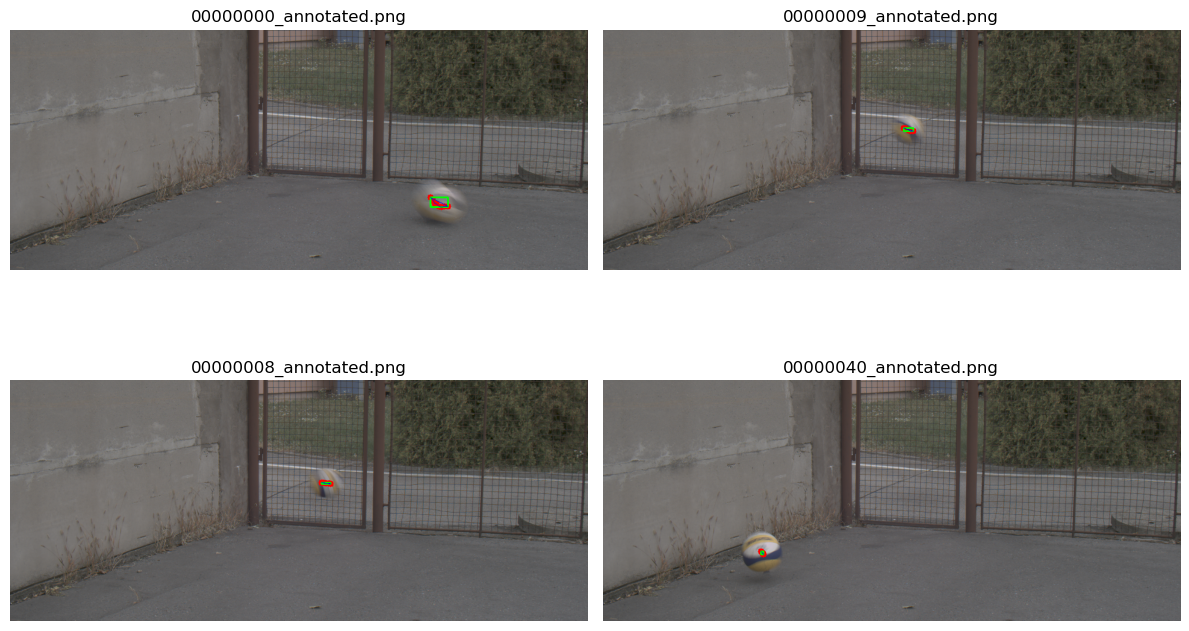

In [54]:
""" Display a sample output """
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List all files in the directory
image_files = os.listdir(tbd_single_seq_output_path)
# Filter for image files (you can adjust the extensions as needed)
image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
# Randomly select 6 images
selected_images = random.sample(image_files, 4) if len(image_files) >= 6 else image_files

plt.figure(figsize=(12, 8))
for i, image_file in enumerate(selected_images):
    img = mpimg.imread(os.path.join(tbd_single_seq_output_path, image_file))
    plt.subplot(2, 2, i + 1)  # 3 rows, 2 columns
    # Extract and display the title part from the filename
    # Format: efficientTAM_traj_Falling_Object_v_box_GTgamma.jpg -> Falling_Object_v_box_GTgamma
    title_part = image_file
    # if image_file.startswith("efficientTAM_traj_"):
    #     title_part = image_file[len("efficientTAM_traj_"):]
    # title_part = os.path.splitext(title_part)[0]
    
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(title_part)
plt.tight_layout()
plt.show()